In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import os
import pickle
import gpflow

import tensorflow as tf
from sklearn.metrics import r2_score

2025-05-18 16:53:40.583090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 16:53:40.604475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747608820.622980   14858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747608820.630318   14858 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 16:53:40.658806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [3]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='08:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

### Setup

In [4]:
# this is not flexible - specifically for lhc, wave1, wave2, and param_* must be global in script. 
def build_X(biome,u_params,pft_params,biome_configs):

    u_lhc = params_lhc[u_params]
    u_wave1 = params_wave1.sel(param=u_params,pft=1)
    u_wave2 = params_wave2[u_params]
    uX = np.concatenate((u_lhc.values,u_wave1.values,u_wave2.values))
    
    X = pd.DataFrame(uX,columns=u_params)
    for pft in biome_configs[biome]['pfts']:
        param_names = [f"{param}_{pft}" for param in pft_params]
        
        p_lhc = params_lhc[pft_params]
        p_wave1 = params_wave1.sel(pft=pft,param=pft_params)
        p_wave2 = params_wave2[param_names]
    
        pX = np.concatenate((p_lhc.values,p_wave1.values,p_wave2.values))
        X = pd.concat([X, pd.DataFrame(pX, columns=param_names)], axis=1)
        
    return X

In [3]:
with open(utils_dir+"/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

In [4]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
               'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

### Load data

In [4]:
######################################################
# load LHC data
infile = '/glade/derecho/scratch/djk2120/postp/c20250424/concat/ctsm6lhc_global_stressors_2000-2023.nc'
ds = xr.open_dataset(infile)

# drop crashers
nan_mask = ds.vcmx25z.isel(biome=3).isnull()
valid = ~nan_mask
ds_lhc = ds.isel(ens=valid)

# load param file
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

ix = np.where(nan_mask)[0]
params_lhc = params.drop(ix-1)

In [8]:
######################################################
# load wave 1 data
infile = '/glade/derecho/scratch/djk2120/postp/c20250424/concat/ctsm6lhc_global_stressors_wave1_2000-2023.nc'
ds = xr.open_dataset(infile)

# drop crashers
nan_mask = ds.vcmx25z.isel(biome=3).isnull()
valid = ~nan_mask
ds_wave1 = ds.isel(ens=valid)

# load parameter file
filename = '/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave1/params/wave1_psets_021725.nc'
w1_params = xr.open_dataset(filename)

ix = np.where(nan_mask)[0]
params_wave1 = w1_params['values'].drop_sel(ens=ix)
params_wave1 = params_wave1.transpose("ens", "param", "pft")
params_wave1 = params_wave1.sel(param=params_lhc.columns)


AttributeError: 'Dataset' object has no attribute 'vcmx25z'

In [7]:
######################################################
### Load Wave 2 data
infile = '/glade/derecho/scratch/djk2120/postp/c20250424/concat/ctsm6lhc_global_stressors_wave2_2000-2023.nc'
ds = xr.open_dataset(infile)

# drop crashers
nan_mask = ds.vcmx25z.isel(biome=3).isnull()
valid = ~nan_mask
ds_wave2 = ds.isel(ens=valid)

# load paramfile
ix = np.where(nan_mask)[0]
df = pd.read_csv('/glade/u/home/linnia/ctsm6_ppe/analysis_lhc/wave2_biome/params/wave2_paramsets_041325.csv')
df = df.iloc[:, 1:]
params_wave2 = df[~df.index.isin(ix)]

### Train biome emulators

In [10]:
np.random.seed(42) 
ntest = 250
X = build_X(13,u_params,pft_params,biome_configs)
ix_test = np.random.choice(np.arange(len(X)), size=ntest, replace=False)
ix_train = np.where(~np.isin(np.arange(len(X)), ix_test))[0]

In [11]:
biome_ix = [1,2,3,4,5,6,7,8,9,10,11,12,13]
vars = ['vcmx25z','ncost','rcost','wstress','alloc','cue']
R2_score = np.empty((len(vars),len(biome_ix)+1))*np.NaN
stdev = np.empty((len(vars),len(biome_ix)+1))*np.NaN

1 Tropical rainforest
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Tropical rainforest/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Tropical rainforest/assets


2 Tropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Tropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Tropical savanna/assets


3 Subtropical savanna
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Subtropical savanna/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Subtropical savanna/assets


4 Broadleaf evergreen temperate tree
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Broadleaf evergreen temperate tree/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Broadleaf evergreen temperate tree/assets


5 Grasslands
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Grasslands/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Grasslands/assets


6 Shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Shrubland/assets


7 Mixed deciduous temperate forest
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Mixed deciduous temperate forest/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Mixed deciduous temperate forest/assets


8 Conifer forest
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Conifer forest/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Conifer forest/assets


9 Siberian larch
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Siberian larch/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Siberian larch/assets


10 Boreal forest
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Boreal forest/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Boreal forest/assets


11 Broadleaf deciduous boreal trees
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Broadleaf deciduous boreal trees/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Broadleaf deciduous boreal trees/assets


12 Boreal shrubland
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Boreal shrubland/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Boreal shrubland/assets


13 Tundra
saving
INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Tundra/assets


INFO:tensorflow:Assets written to: ./emulators_biome_alloc/Tundra/assets


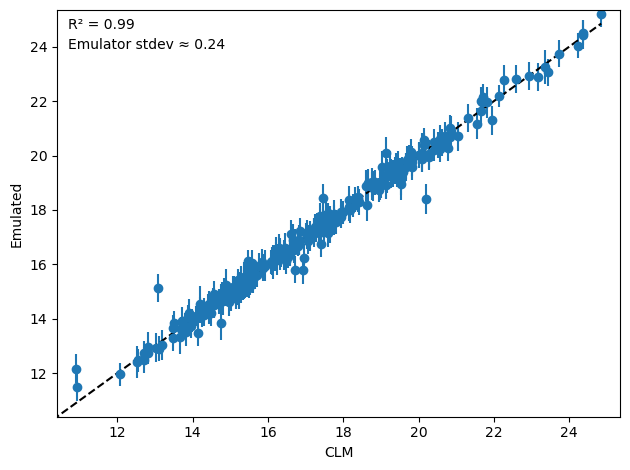

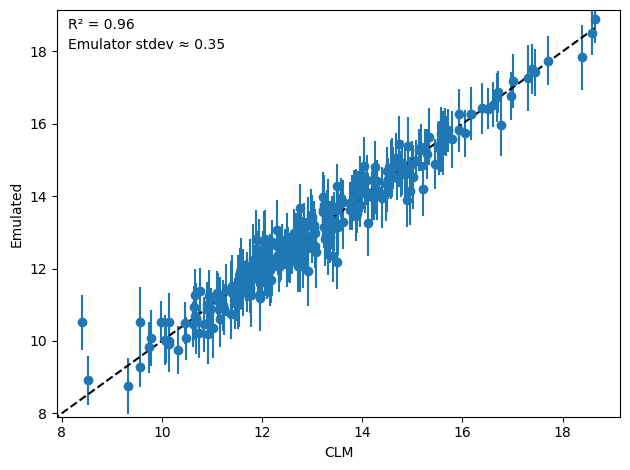

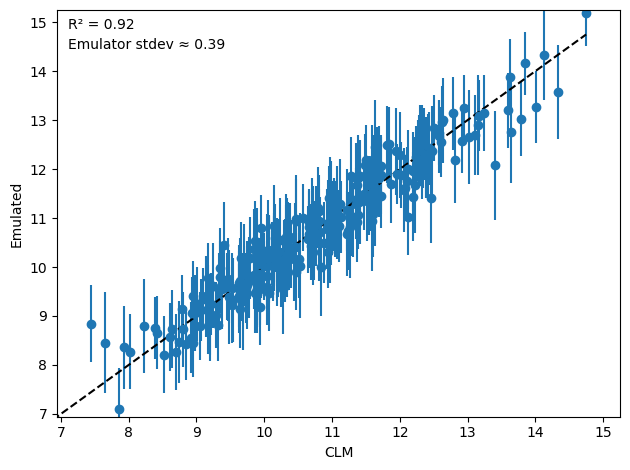

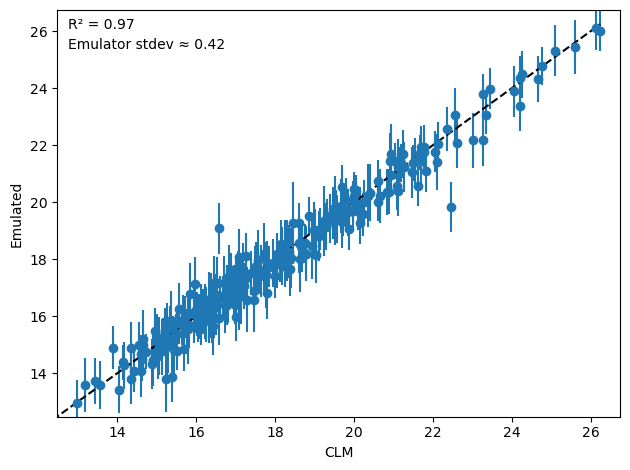

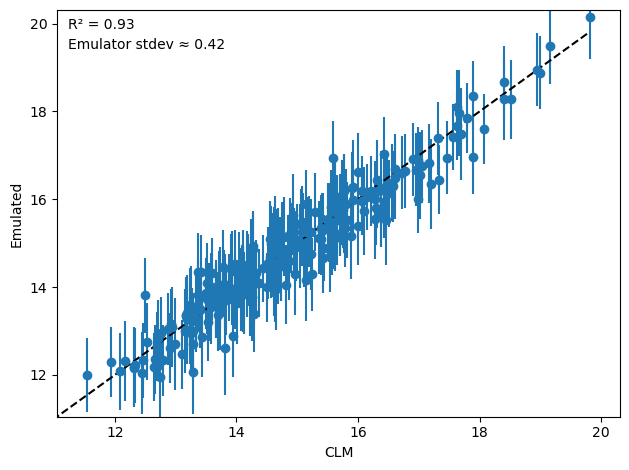

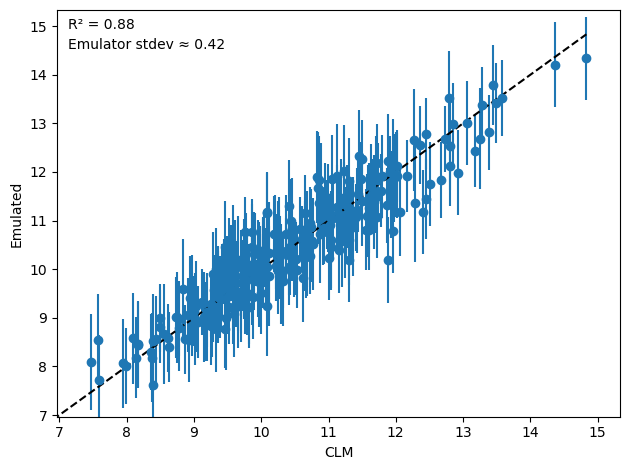

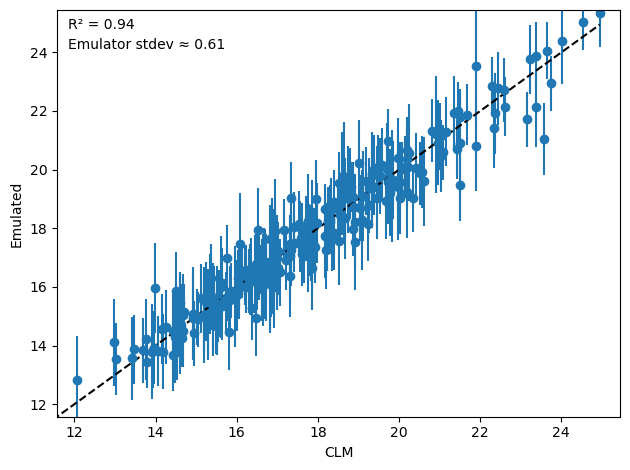

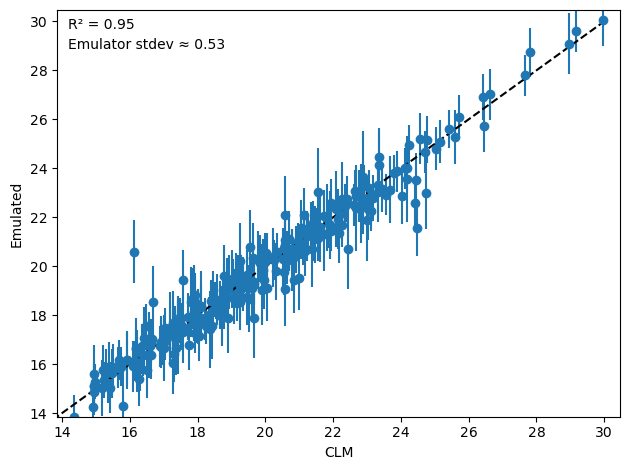

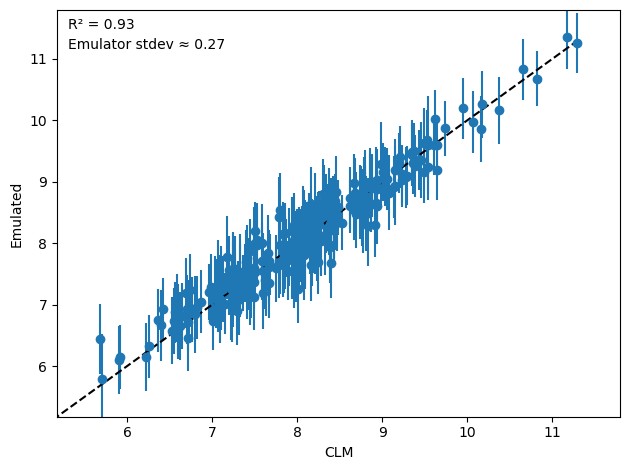

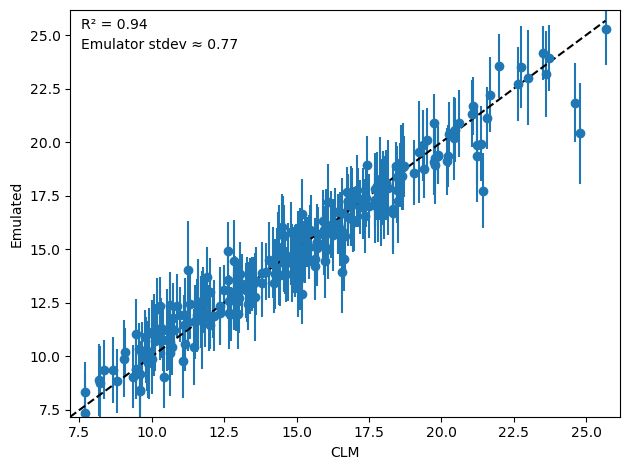

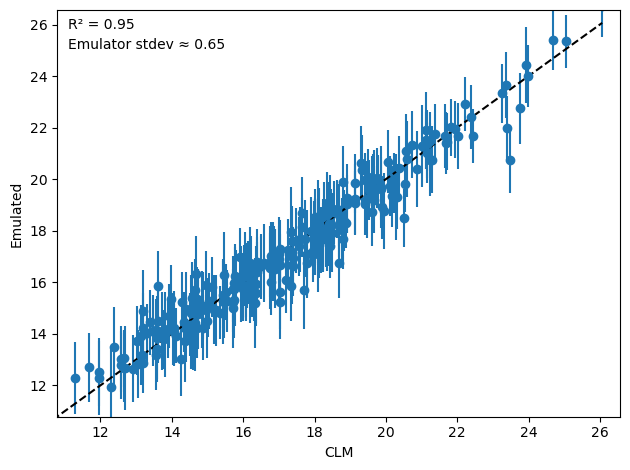

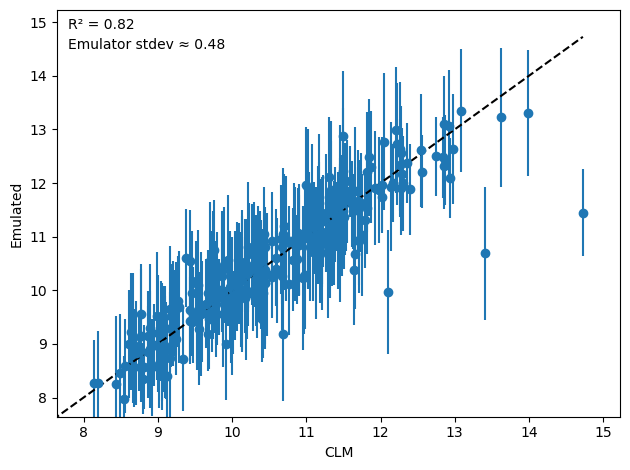

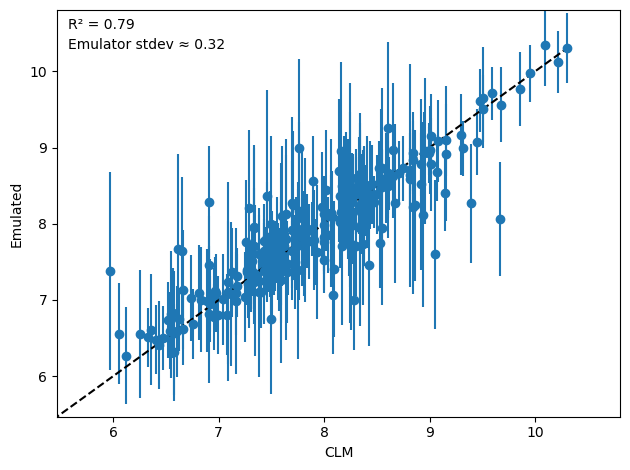

In [15]:
# Train emulators
vars = ['alloc']
for v, var in enumerate(vars):
    for b in biome_ix:
        biome_name = biome_configs[b]['name']
        print(b, biome_name)
        
        X = build_X(b,u_params,pft_params,biome_configs)
        y_lhc = ds_lhc[var].sel(biome=b).values[1:]
        y_wave1 = ds_wave1[var].sel(biome=b).values
        y_wave2 = ds_wave2[var].sel(biome=b).values
        Y = np.concatenate((y_lhc,y_wave1,y_wave2))
        if var == "alloc":
            Y = Y/10000
        
        X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
        y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)
    
        num_params = np.shape(X)[1]
        kernel_dict = build_kernel_dict(num_params)
        outfile = './figs/'+biome_name+'_emulator_validation_biome_'+var+'.png'
        savedir = str('./emulators_biome_'+var+'/'+biome_name)
        best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
        #best_kernel = kernel_dict[6]
        R2_score[v,b], stdev[v,b] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
        

In [16]:
R2_score

array([[       nan, 0.98579442, 0.95613398, 0.91760734, 0.96739258,
        0.9267556 , 0.87579357, 0.93796188, 0.95035139, 0.93307979,
        0.94405195, 0.94838221, 0.81771282, 0.79080858],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan,    

### Train global emulators

In [20]:
# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('default_params_norm.csv', index_col=False)

In [25]:
# set up global X input params (2500x236)
u_lhc = params_lhc[u_params]
u_wave1 = params_wave1.sel(param=u_params,pft=1)
u_wave2 = params_wave2[u_params]
uX = np.concatenate((u_lhc.values,u_wave1.values,u_wave2.values))
    
X = pd.DataFrame(uX,columns=u_params)
for pft in [1,2,3,4,5,6,7,8,10,11,12,13,14]:
    param_names = [f"{param}_{pft}" for param in pft_params]
    
    p_lhc = params_lhc[pft_params]
    p_wave1 = params_wave1.sel(pft=pft,param=pft_params)
    p_wave2 = params_wave2[param_names]

    pX = np.concatenate((p_lhc.values,p_wave1.values,p_wave2.values))
    X = pd.concat([X, pd.DataFrame(pX, columns=param_names)], axis=1)
    
# reorder like default
X = X[default_params.columns.values]

In [27]:
np.random.seed(42) 
ntest = 250
ix_test = np.random.choice(np.arange(len(X)), size=ntest, replace=False)
ix_train = np.where(~np.isin(np.arange(len(X)), ix_test))[0]

In [26]:
vars = ['vcmx25z','ncost','rcost','wstress','alloc','cue']
R2_score = np.empty(len(vars))*np.NaN
stdev = np.empty(len(vars))*np.NaN

saving
INFO:tensorflow:Assets written to: ./emulators_global/alloc/assets


INFO:tensorflow:Assets written to: ./emulators_global/alloc/assets


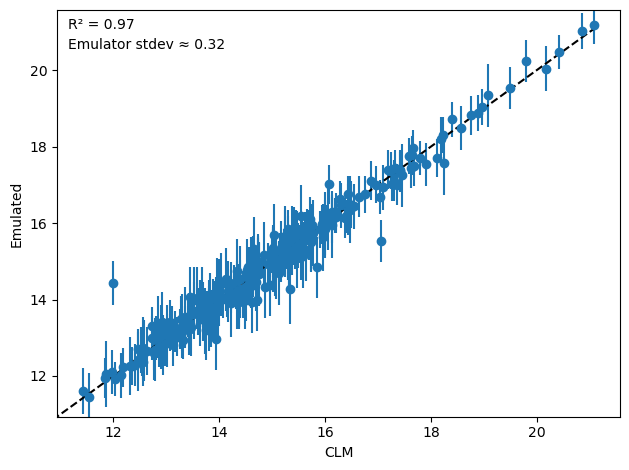

In [35]:
# Train global emulators
vars = ['alloc']
for v, var in enumerate(vars):
    
    y_lhc = ds_lhc[var].sel(biome=14).values[1:]
    y_wave1 = ds_wave1[var].sel(biome=14).values
    y_wave2 = ds_wave2[var].sel(biome=14).values
    Y = np.concatenate((y_lhc,y_wave1,y_wave2))
    if var == "alloc":
        Y = Y/10000
    
    X_test, X_train = X.values[ix_test,:], X.values[ix_train,:]
    y_test, y_train = Y[ix_test].reshape(-1,1), Y[ix_train].reshape(-1,1)

    num_params = np.shape(X)[1]
    kernel_dict = build_kernel_dict(num_params)
    outfile = './figs/emulator_validation_global_'+var+'.png'
    savedir = str('./emulators_global/'+var)
    #best_kernel = select_kernel(kernel_dict,X_train,X_test,y_train,y_test)
    best_kernel = kernel_dict[6]
    R2_score[v], stdev[v] = train_val_save(X_train,X_test,y_train,y_test,best_kernel,outfile=outfile,savedir=savedir)
    

In [36]:
R2_score

array([0.96742792, 0.91489989, 0.93570182, 0.97862401, 0.92263094,
       0.94606531])

### Plot R2_score

In [ ]:
row_names = ['LAI', 'GPP', 'TOTVEGC']
df = pd.DataFrame(R2_all,columns=biome_names[1:],index=row_names)

In [ ]:
import seaborn as sns

In [ ]:

plt.figure(figsize=(10, 5))
ax = sns.heatmap(df, annot=True, cmap='magma', vmin=0, vmax=1, fmt=".2f", linewidths=0.5,
                 annot_kws={"size": 12})  # Adjust annotation font size
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('./figs/emulator_evaluation_heatmap.png',dpi=200)